In [1]:
!pip install tensorflow==2.3.1 gym keras-rl2==1.0.4 gym[atari]==0.18.0

In [2]:
import tensorflow as tf
import gym


print("TensorFlow version:", tf.__version__)
print("Gym version:", gym.__version__)


2023-07-08 20:54:56.370274: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2023-07-08 20:54:56.370337: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.3.1
Gym version: 0.18.0


In [2]:
import gym
import random
import os

In [3]:
env = gym.make('SpaceInvaders-v0')
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [5]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        ##env.render()
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()


Episode:1 Score:360.0
Episode:2 Score:140.0
Episode:3 Score:120.0
Episode:4 Score:35.0
Episode:5 Score:125.0


In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

2023-07-08 22:26:58.717681: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/luca/anaconda3/envs/prjIA2/lib/python3.7/site-packages/cv2/../../lib64:
2023-07-08 22:26:58.717697: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [6]:
def build_model(height, width, channels, actions):
    model = Sequential()
    #Camadas convolucionais:
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    #cria camada convolucional 2D com 32 filtros de tamanho 8x8 strides 4x4 -se movem 4 pixels na altura e 4 pixels na largura a cada passo)
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    #Camadas densas
    #usadas para mapear os recursos extraídos pelas camadas convolucionais em ações ou 
    #valores Q em problemas de aprendizagem por reforço.
    model.add(Dense(512, activation='relu')) #camada com 512 neuronios
    model.add(Dense(256, activation='relu')) #camada densa com 256 
    model.add(Dense(actions, activation='linear')) #Cria a ultima camada com numero de neurônos iguais a de açãoes posssiveis no jogo, 6
    return model

In [7]:
    #Função para criar o agente
    def build_agent(model, actions):
        #politica de exploração 
        policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=1000)
        #memoria   armazenar as transições (estado, ação, recompensa, próximo estado) 
        #para posteriormente utilizar no treinamento do agente.
        memory = SequentialMemory(limit=1000, window_length=3)
        #Criando o agente de aprendizado por reforço
        dqn = DQNAgent(model=model, memory=memory, policy=policy,
                       enable_dueling_network=True, dueling_type='avg',  ##rede dueling separa a estimativa valor do estado e valor da ação
                       nb_actions=actions, nb_steps_warmup=1000 ##joga 10000 vezes com ações aleatórias antes de aprender
                      )
        return dqn

In [8]:
model = build_model(height, width, channels, actions)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten (Flatten)            (None, 67584)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               34603520  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

In [10]:
dqn = build_agent(model, actions) ### criando o agente
dqn.compile(Adam(lr=1e-4))
##otimizador Adam com uma taxa de aprendizado (learning rate) de 1e-4 (0.0001).


2023-07-08 22:27:11.567152: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-07-08 22:27:11.597200: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-08 22:27:11.597230: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luca-Aspire-A515-54): /proc/driver/nvidia/version does not exist
2023-07-08 22:27:11.598144: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 22:27:11.630327: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2299965000 Hz
2023-07-08 22:27:11.630957: I 

In [13]:
del model

In [11]:
#Inicia o treinamento do agente
dqn.fit(env, nb_steps=1000000, visualize=False, verbose=2)
#passa o ambiente env, treina 100000 vezes, visualize falso pois não copila aqui,
#verbose=2 para ter mais detalhamento 

Training for 1000000 steps ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2023-07-07 17:32:01.713556: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 138412032 exceeds 10% of free system memory.


done, took 7.006 seconds


In [17]:
#Salvando o Pesos
dqn.save_weights('Agente_D1_64ep')

In [35]:
data_random = np.load("scores/pontuacao_random_ep.npy")
data_64ep = np.load("scores/pontuacao_64_ep.npy")
data_10kep = np.load("scores/pontuacao_10k_ep.npy")
data_1mep = np.load("scores/pontuacao_1m_ep.npy")


data_random = np.delete(data_random, -1)
data_1mep = np.delete(data_1mep, -1)


In [27]:
!pip install matplotlib

  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 5.8 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.4-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)


In [36]:
print(len(data_random))
print(len(data_64ep))
print(len(data_10kep))
print(len(data_1mep))

100
100
100
100


Text(0.5, 1.0, 'Comparação de treinos')

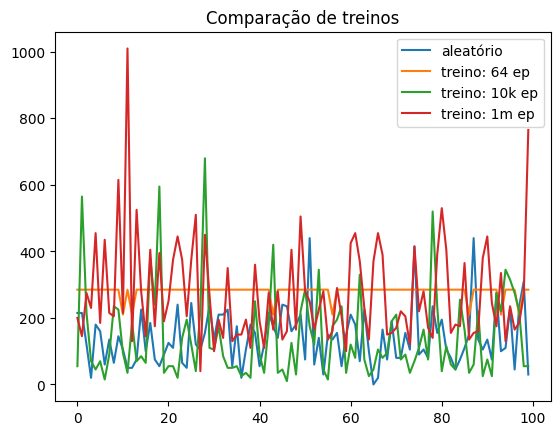

In [38]:
import matplotlib.pyplot as plt

indices = np.arange(len(data_random))

plt.plot(indices, data_random, label='aleatório')
plt.plot(indices, data_64ep, label='treino: 64 ep')
plt.plot(indices, data_10kep, label='treino: 10k ep')
plt.plot(indices, data_1mep, label='treino: 1m ep')


plt.legend()
plt.title('Comparação de treinos')

Text(0.5, 1.0, 'Agente treinado por 64 episódios')

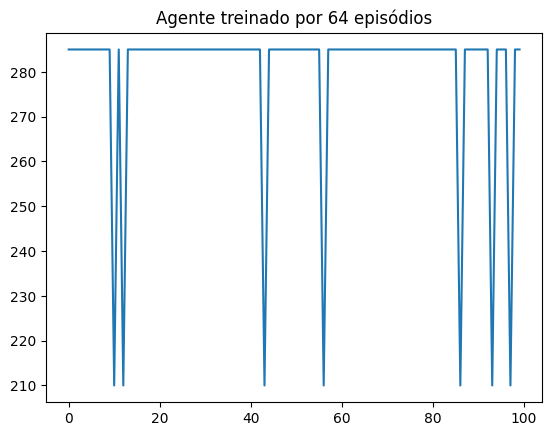

In [49]:
indices = np.arange(len(data_random))

plt.plot(indices, data_64ep, label='treino: 64 ep')


##plt.legend()
plt.title('Agente treinado por 64 episódios')

Text(0.5, 1.0, '64 ep vs 1.000.000 ep')

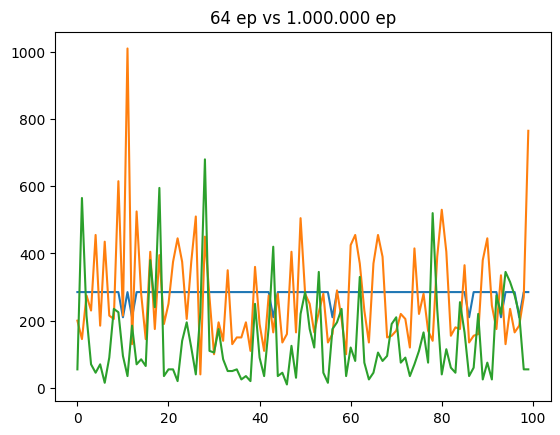

In [52]:
indices = np.arange(len(data_random))

plt.plot(indices, data_64ep, label='treino: 64 ep')
plt.plot(indices, data_1mep, label='treino: 1m ep')
plt.plot(indices, data_10kep, label='treino: 10k ep')

##plt.legend()
plt.title('64 ep vs 1.000.000 ep')


Text(0.5, 1.0, '64 ep vs 1.000.000 ep')

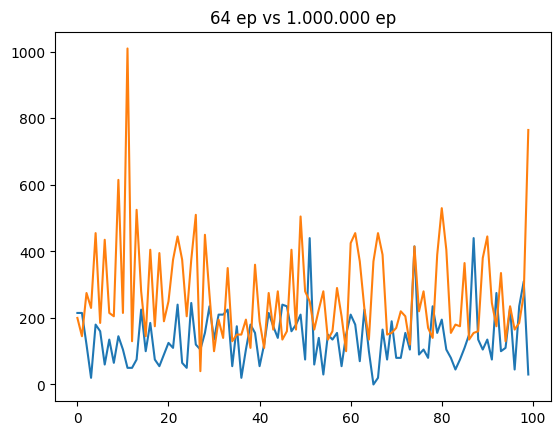

In [51]:
indices = np.arange(len(data_random))

plt.plot(indices, data_random, label='aleatório')
plt.plot(indices, data_1mep, label='treino: 1m ep')


##plt.legend()
plt.title('random vs 1.000.000 ep')

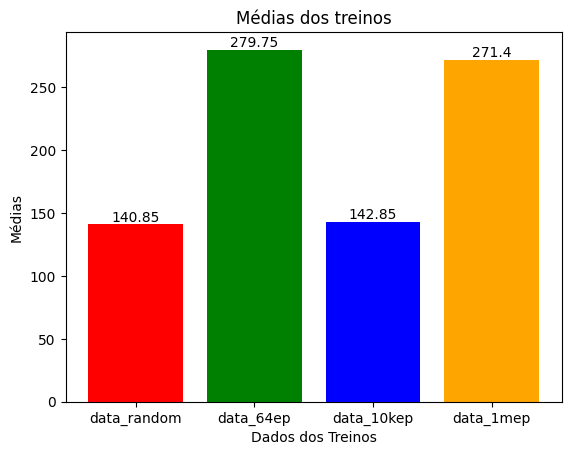

In [40]:
medias = [np.mean(data_random), np.mean(data_64ep), np.mean(data_10kep), np.mean(data_1mep)]
labels = ['data_random', 'data_64ep', 'data_10kep', 'data_1mep']
colors = ['red', 'green', 'blue', 'orange']


plt.bar(labels, medias, color=colors)

for i, valor in enumerate(medias):
    plt.text(i, valor, str(valor), ha='center', va='bottom')
    
plt.xlabel('Dados dos Treinos')
plt.ylabel('Médias')
plt.title('Médias dos treinos')

plt.show()


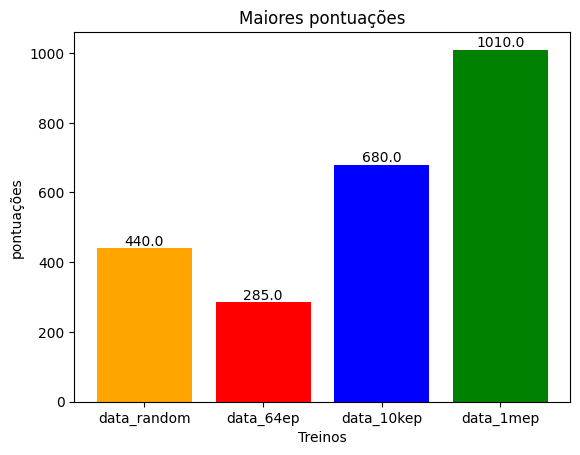

In [43]:
valores_maximos = [np.max(data_random), np.max(data_64ep), np.max(data_10kep), np.max(data_1mep)]
labels = ['data_random', 'data_64ep', 'data_10kep', 'data_1mep']
colors = ['orange', 'red', 'blue', 'green']

plt.bar(labels, valores_maximos, color=colors)

for i, valor in enumerate(valores_maximos):
    plt.text(i, valor, str(valor), ha='center', va='bottom')

plt.xlabel('Treinos')
plt.ylabel('pontuações')
plt.title('Maiores pontuações')

plt.show()